# Stance detection

Stance detection for comparative questions is the task consisting of determining, given a comparative question $Q$ between two objects $O_1$ and $O_2$ and an answer $A$, the stance of $A$ with respect to $Q$. The answer can either express:
- No stance;
- Neutrality;
- Being in favour of $O_1$;
- Being in favour of $O_2$.

Needed libraries:

In [1]:
!pip install transformers

In [2]:
from dataclasses import dataclass
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tqdm
from transformers import logging, DistilBertTokenizer, TFDistilBertForSequenceClassification

import utils.manage_files

In [3]:
@dataclass
class StanceConfig:
    DATASET_PATH = 'touche22-task2-stance-dataset.tsv'
    INIT_LR = 1e-5
    LR_REDUCTION_FACTOR_PLATEAU = .1
    MIN_LR = 1e-8
    
    MODEL_BATCH_SIZE = 16
    MODEL_CHECKPOINT_FOLDER = './model_checkpoint/'
    MODEL_EPOCHS = 150
    
    MODEL_NNO_BATCH_SIZE = 16
    MODEL_NNO_CHECKPOINT_FOLDER = './model_nno_checkpoint/'
    MODEL_NNO_EPOCHS = 150
    
    MODEL_NNO_WEIGHTED_BATCH_SIZE = 16
    MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER = './model_nno_checkpoint_weighted/'
    MODEL_NNO_WEIGHTED_EPOCHS = 150
    
    MODEL_OBJ_BATCH_SIZE = 16
    MODEL_OBJ_CHECKPOINT_FOLDER = './model_obj_checkpoint/'
    MODEL_OBJ_EPOCHS = 150
    
    MODEL_OBJ_WEIGHTED_BATCH_SIZE = 16
    MODEL_OBJ_WEIGHTED_CHECKPOINT_FOLDER = './model_obj_checkpoint_weighted/'
    MODEL_OBJ_WEIGHTED_EPOCHS = 150
    
    SEED = 42
    TRAIN_VAL_TEST_RATIOS = {'train': .8, 'val': .1, 'test': .1}

stance_config = StanceConfig()
logging.set_verbosity(40) #Due to an annoying repeated warning given by the tokenizer.

## Dataset exploration

In [4]:
df = pd.read_csv(stance_config.DATASET_PATH, sep='\t')
df.head()

,ds,id,question,answer,answer_stance,answer_stance_object,object_count,object_1,mask_pos_1,object_2,mask_pos_2
0,softwareengineering.stackexchange,10373,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",2,simple but more expensive,2,simple but more expensive,"[[231, 252], [389, 393], [605, 619], [753, 757]]",complicated but cheaper,[]
1,softwareengineering.stackexchange,18838,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",2,Haskell AND Lisp,2,Haskell AND Lisp,"[[25, 56]]",Haskell OR Lisp,[]
2,softwareengineering.stackexchange,19392,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,3,do it in code,2,offload work to the RDBMS,"[[40, 55], [232, 248]]",do it in code,"[[165, 175], [578, 598]]"
3,softwareengineering.stackexchange,20653,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",3,expand into other fields to broaden my horizons,2,to specialize in a single field I like,"[[53, 63], [404, 410], [512, 519]]",expand into other fields to broaden my horizons,"[[892, 933]]"
4,softwareengineering.stackexchange,21186,Microsoft SDE Interview vs Microsoft SDET Inte...,"Unfortunately, those are both myths. SDEs and ...",1,Neutral,2,Microsoft SDE Interview,"[[37, 41], [283, 295], [950, 962]]",Microsoft SDET Interview,"[[46, 51], [341, 354], [832, 836], [938, 945]]"


For the current task, only the columns "question", "answer" and "answer_stance" are needed, since the aim of this section is to build a model able to tell the stance of the answer with respect to the asked question, as described. We also include the "dataset" column in order to be sure that we're hiding (as per license conditions) the records coming from the dataset kindly provided by Yahoo.

In [5]:
df = df.loc[:, ['ds','question','answer','answer_stance']]
df.head()

,ds,question,answer,answer_stance
0,softwareengineering.stackexchange,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",2
1,softwareengineering.stackexchange,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",2
2,softwareengineering.stackexchange,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,3
3,softwareengineering.stackexchange,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",3
4,softwareengineering.stackexchange,Microsoft SDE Interview vs Microsoft SDET Inte...,"Unfortunately, those are both myths. SDEs and ...",1


We take a look at the distribution of the classes in the whole dataset:

<AxesSubplot:>

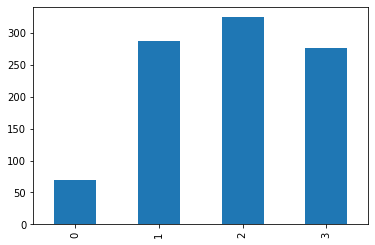

In [6]:
df.answer_stance.value_counts().sort_index().plot(kind='bar')

We will take into account the fact that the distribution of the classes is not uniform, but not immediately.

## Models implementation

### Distilbert with 4 classes

For the task of stance detection, we agreed on the fact that a network based on Bidirectional Encoder Representations from Transformers (usually referred to as "Bert") was the way to go. In particular, we decided to fine-tune a network built upon the DistilBERT architecture ([typeform/distilbert-base-uncased-mnli · Hugging Face](https://huggingface.co/typeform/distilbert-base-uncased-mnli)).

Retrieving the tokenizer:

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")

Retrieving the model:

In [54]:
model = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=4, ignore_mismatched_sizes=True)

Quick look at its structure:

In [55]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_99 (Dropout)        multiple                  0         
                                                                 
Total params: 66,956,548
Trainable params: 66,956,548
Non-trainable params: 0
_________________________________________________________________


We want to fine-tune the model, therefore we freeze the part of the network responsible of taking care of the *encoding* part of the process, and then we compile it.

In [56]:
model.distilbert.trainable = False
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate = stance_config.INIT_LR),
    metrics=keras.metrics.SparseCategoricalAccuracy()
)

Before proceeding, for reproducibility, we fix the random seeds:

In [8]:
def set_reproducibility(seed: int) -> None:
    """
    Fixes a given seed for the pseudo-random number generators.
    Args:
        seed (int): seed to fix
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(stance_config.SEED)

Defining the train, val, test splits:

In [9]:
def train_val_test_splits(df: pd.DataFrame, ratios:dict, blueprint:bool = False) -> dict:
    """
    Splits a given DataFrame into train, val and test, according to the provided ratios.
    The dataframe is expected to contain the columns "question" and "answer". Other columns will be ignored.

    Args:
        df (pandas.DataFrame): The DataFrame that has to be splitted into train, val and test sets.
        ratios (dict): The dictionary containing the ratios between the contents of the train, val and test set. Expected keys: 'train', 'val', 'test'. Expected values: positive numbers not exceeding 1.
        blueprint (bool): Flag to determine whether the function should just return the dictionary that will contain the required splits.
    Returns:
        dict: dictionary containing the required splits. Available keys: 'x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test'.
    """

    if blueprint:
        return {'x_train': None, 'x_val': None, 'x_test': None, 'y_train': None, 'y_val': None, 'y_test': None}
    
    #Separating "train" from "val and test"
    x_train, x_val_test, y_train, y_val_test = train_test_split(df.loc[:,['question','answer']],df.loc[:,['answer_stance']],test_size=ratios['test'] + ratios['val'], train_size=ratios['train'])
    
    #Separating "val" from "test"
    x_val, x_test, y_val, y_test = train_test_split(x_val_test,y_val_test,test_size = ratios['test']/(ratios['test'] + ratios['val']), train_size=ratios['val']/(ratios['test'] + ratios['val']))
    
    return {'x_train': x_train, 'x_val': x_val, 'x_test': x_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

In [13]:
ratios = stance_config.TRAIN_VAL_TEST_RATIOS
list_ratios = list(ratios.values())

#Ensuring that the values represent proper proportions (no zeros allowed).
assert np.sum(list_ratios) == 1 and np.sum(np.sign(list_ratios)) == 3, 'Please specfy valid ratios for the "train, val, test" split.'

ds_splits_untok = train_val_test_splits(df, ratios)
ds_splits = train_val_test_splits(None, None, True)

Processing the sets with the selected `DistilBertTokenizer`:

In [10]:
def tokenize_df(question_answer_df: pd.DataFrame, tokenizer: DistilBertTokenizer) -> dict:
    """
    Given a DistilBertTokenizer, the function returns a dictionary containing the tokenized version of the inputs that will be fed to the networks.
    
    Args:
        question_answer_df (pandas.DataFrame): The DataFrame whose contents have to be tokenized.
        tokenizer (DistilBertTokenizer): The DistilBertTokenizer instance loaded from a pre-trained model.
    Returns:
        dict: dictionary containing the tokenized version of the inputs that will be fed to the networks.
    """
    
    #From the dataframe we build the list of lists which contains the values of the dataframe. In particular, each
    #element of the outer list is a two-elements list containing the values of a certain row of the dataframe.
    LL = question_answer_df.values.tolist()
    
    #Now, the tokenizer can generate the proper arrays that we'll feed to the networks.    
    return dict(tokenizer(LL, padding=True, truncation='longest_first', return_tensors='tf'))

In [15]:
#Tokenizing the inputs and preparing the outputs
for set_name in ['train','val','test']:
    ds_splits[f'x_{set_name}'] = tokenize_df(ds_splits_untok[f'x_{set_name}'],tokenizer)
    ds_splits[f'y_{set_name}'] = ds_splits_untok[f'y_{set_name}'].to_numpy().flatten()

#### Training

We configure two callbacks, one for saving the model weights at the best epoch (***ModelCheckpoint***) and the other to reduce gradually the learning rate (***ReduceLROnPlateau***).

We configure 2 callbacks for the training, ***ModelCheckpoint*** to save the weights at the best epoch and ***ReduceLROnPlateau*** to reduce the learning rate during the training.

Ensuring that the folder needed to store the best weights of the network exist:

In [17]:
os.makedirs(stance_config.MODEL_CHECKPOINT_FOLDER, exist_ok = True)

print('Model checkpoint folder created (if not existent). If the training has been already done, please copy the corresponding weights in the following folder:')
print(os.path.abspath(stance_config.MODEL_CHECKPOINT_FOLDER))

Model checkpoint folder created (if not existent). If the training has been already done, please copy the corresponding weights in the following folder:
C:\Users\Andrea\Script Python\model_checkpoint


Starting the training of the networks (or loading the weights if available):

In [19]:
history = None

try:
    model.load_weights(stance_config.MODEL_CHECKPOINT_FOLDER)
    print('The weights of the model have already been found. Skipping training.')

except:
    
    history = model.fit(
        ds_splits['x_train'], 
        ds_splits['y_train'], 
        validation_data = (
            ds_splits['x_val'],
            ds_splits['y_val']
        ),
        epochs = stance_config.MODEL_EPOCHS,
        callbacks = model_callbacks,
        batch_size = stance_config.MODEL_BATCH_SIZE
    )

    #Finally, load the best weights obtained during the training:
    model.load_weights(stance_config.MODEL_CHECKPOINT_FOLDER)

Epoch 1/150
48/48 [==============================] - ETA: 0s - loss: 1.3951 - sparse_categorical_accuracy: 0.2291
Epoch 1: val_loss improved from inf to 1.36376, saving model to ./model_checkpoint\
48/48 [==============================] - 25s 386ms/step - loss: 1.3951 - sparse_categorical_accuracy: 0.2291 - val_loss: 1.3638 - val_sparse_categorical_accuracy: 0.2708 - lr: 1.0000e-05
Epoch 2/150
48/48 [==============================] - ETA: 0s - loss: 1.3419 - sparse_categorical_accuracy: 0.2984
Epoch 2: val_loss improved from 1.36376 to 1.33243, saving model to ./model_checkpoint\
48/48 [==============================] - 20s 429ms/step - loss: 1.3419 - sparse_categorical_accuracy: 0.2984 - val_loss: 1.3324 - val_sparse_categorical_accuracy: 0.2917 - lr: 1.0000e-05
Epoch 3/150
48/48 [==============================] - ETA: 0s - loss: 1.3216 - sparse_categorical_accuracy: 0.3154
Epoch 3: val_loss improved from 1.33243 to 1.30938, saving model to ./model_checkpoint\
48/48 [=================

Let us inspect the history of the training of both networks:

In [26]:
def display_history(history: keras.callbacks.History) -> None:
    """Plots the history of the training of a certain model.

    Args:
        history (keras.callbacks.History): History of the training of a model.

    """
    if history is not None:
        train_loss = history.history['loss']

        val_loss = history.history['val_loss']

        # Visualize the behavior of the loss
        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.grid()
        plt.title('Loss during training')
        plt.xlabel('Epoch')
        plt.legend(['Training', 'Validation'])
        plt.show()
    else:
        print('No history available. The weights have been loaded manually.')

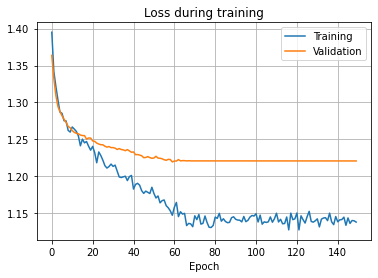

In [21]:
display_history(history)

From the data we can infer the epoch that allowed the model to generalize better by inspecting the loss on data that it had never seen before (data on the validation set).

In [22]:
if history is None:
    print(f'The data cannot be calculated since the history of the training of the model is not available.')
else:
    print(f'The model currently uses the weights that have been determined on epoch {np.argmin(history.history["val_loss"]) + 1}.')

The model currently uses the weights that have been determined on epoch 60.


The following classification report sums up the performances of the trained networks with respect to the test data.

In [23]:
print(f'Classification report for the Model:')    
y_true = ds_splits['y_test']
y_pred = np.argmax(model.predict(ds_splits['x_test']).logits,axis=-1)
print(classification_report(y_true, y_pred, zero_division = 0))

Classification report for the Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.47      0.76      0.58        25
           2       0.45      0.30      0.36        43
           3       0.33      0.39      0.36        23

    accuracy                           0.43        96
   macro avg       0.31      0.36      0.33        96
weighted avg       0.40      0.43      0.40        96



Considering we had scarcely any records that could be used to train our data, we don't expect good performances. We just aim to be, at least, better than a random classifier. Furthermore, the distribution of the classes is heavily unbalanced, meaning that it does not resemble an uniform distribution at all.

The following section sets up a random classifier, in order to be able to compare the performances of the models with the performances of a random classifier (classes assigned by sampling from an uniform distribution). We want to inspect the macro averages and the weighted averages of precision, recall and f1-scores. Given the randomness of the experiment, we collect the metrics many times and then calculate mean and variance of those measures.

In [11]:
def random_experiment(model_list: list, y_true_list: list, range_list: list, NUM_EXPERIMENTS: int, NUM_DECIMALS: int = 3) -> None:
    """Evaluates how the models in model_list would perform given the true labels and the range of the labels (thought as numbers).
    NUM_EXPERIMENTS runs will be performed and the results will be displayed on screen with a number of decimals equal to NUM_DECIMALS.
    Args:
        model_list (list): The list of models to test.
        y_true_list (list): The list of lists of true labels. The first element of y_true_list must contain the list of true labels for the first model, and so on and so forth.
        range_list (list): The list of dictionaries with keys "min" and "max" describing the minimum and maximum label that each model in model_list can output.
        NUM_EXPERIMENTS (int): The number of experiments that will be run.
        NUM_DECIMAL (int): The number of decimals that have to be printed to describe the computed statistics.
    """
    assert len(model_list) == len(y_true_list) and NUM_EXPERIMENTS > 0, 'Invalid arguments'
    
    #The dictionary that will contain the output
    measures_dict = {model: {'macro': [], 'weighted':[]} for model in model_list}
    
    for _ in tqdm.tqdm(range(NUM_EXPERIMENTS)):
        for i in range(len(model_list)):
            model = model_list[i]
            y_true = y_true_list[i]
            y_true_min = range_list[i]['min']
            y_true_max = range_list[i]['max']
            
            y_pred = np.random.randint(y_true_min, y_true_max + 1, y_true.shape)
            cr = classification_report(y_true, y_pred, zero_division = 0, output_dict = True)
            measures_dict[model]['macro'].append(cr['macro avg'])
            measures_dict[model]['weighted'].append(cr['weighted avg'])
    
    precisions = {model: {'macro': [], 'weighted':[]} for model in model_list}
    recall = {model: {'macro': [], 'weighted':[]} for model in model_list}
    f1_score = {model: {'macro': [], 'weighted':[]} for model in model_list}
    
    for model in model_list:
        for avg_type in measures_dict[model]:
            for scores in measures_dict[model][avg_type]:
                precisions[model][avg_type].append(scores['precision'])
                recall[model][avg_type].append(scores['recall'])
                f1_score[model][avg_type].append(scores['f1-score'])

    #Computing averages in place
    for model in model_list:
        for avg_type in measures_dict[model]:
            precisions[model][avg_type] = {'mean': np.mean(precisions[model][avg_type]), 'var': np.var(precisions[model][avg_type])}
            recall[model][avg_type] = {'mean': np.mean(recall[model][avg_type]), 'var': np.var(recall[model][avg_type])}
            f1_score[model][avg_type] = {'mean': np.mean(f1_score[model][avg_type]), 'var': np.var(f1_score[model][avg_type])}
            
    tab = '\t'
    for i in range(len(model_list)):
        print(f'Approximation of the expected performances of a uniform random classifier for the task solved by Model {i+1}')
        for avg_type in ['macro', 'weighted']:
            print(tab + avg_type[0].upper() + avg_type[1:] + ':')
            for metric_name, metric in [('Precision:', precisions), ('Recall', recall), ('F1-score', f1_score)]:
                print(2*tab + metric_name)
                for stat in ['mean','var']:
                    print(3*tab + stat[0].upper() + stat[1:] + ':' + ("{:." + str(NUM_DECIMALS) + "f}").format(metric[model_list[i]][avg_type][stat]))

In [25]:
random_experiment([model], [ds_splits['y_test']], [{'min':0, 'max':3}], 1000, 3) 

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.24it/s]

Approximation of the expected performances of a uniform random classifier for the task solved by Model 1
	Macro:
		Precision:
			Mean:0.250
			Var:0.002
		Recall
			Mean:0.251
			Var:0.004
		F1-score
			Mean:0.225
			Var:0.002
	Weighted:
		Precision:
			Mean:0.329
			Var:0.003
		Recall
			Mean:0.250
			Var:0.002
		F1-score
			Mean:0.271
			Var:0.002


### Two models classification

The literature, for example through the paper "[LeviRANK: Limited Query Expansion with Voting Integration for Document Retrieval and Ranking](https://ceur-ws.org/Vol-3180/paper-259.pdf)", provides some results according to which the performances (in terms of quality of the predictions) can be improved by splitting the task above in the two sub-tasks consisting of initially determining whether the stance is "No stance", "Neutrality" or "Being in favour of $O_x$" ($x \in \{1,2\}$) and then, if the last evaluation yielded "Being in favour of $O_x$", determining whether $x$ is $1$ or $2$. We will try this approach.

We'll start by splitting the dataset in two different ones:
- `df_nno`: used to train a network focused on determining whether the stance is "No stance", "Neutrality" or "Being in favour of $O_x$" ($x \in \{1,2\}$);
- `df_obj`: used to train a network focused on determining whether the stance is "Being in favour of $O_1$" or "Being in favour of $O_2$".

In particular, the first dataset will remove the distinction between `answer_stance` being equal to $2$ or $3$, the second dataset will consider ONLY the pairs (`question`, `answer`) whose `answer_stance` is either $2$ or $3$.

In [12]:
df_nno = df.copy()
df_obj = df.copy()

#The answer stances "Being in favour of O_1/2" must become indistinguishable from each other.
df_nno.loc[df_nno.answer_stance == 3, 'answer_stance'] = 2

#The only answer stances that we're considering are "Being in favour of O_1/2".
df_obj = df_obj.loc[df_obj.answer_stance.isin([2,3]),:]

#Remapping the answer stances "2" and "3" to, respectively, "0" and "1"
df_obj.answer_stance -= 2

Viewing the resulting DataFrames:

In [13]:
df_nno.head()

,ds,question,answer,answer_stance
0,softwareengineering.stackexchange,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",2
1,softwareengineering.stackexchange,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",2
2,softwareengineering.stackexchange,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,2
3,softwareengineering.stackexchange,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",2
4,softwareengineering.stackexchange,Microsoft SDE Interview vs Microsoft SDET Inte...,"Unfortunately, those are both myths. SDEs and ...",1


In [14]:
df_obj.head()

,ds,question,answer,answer_stance
0,softwareengineering.stackexchange,What's the better way to charge for a cloud pl...,"Like all good questions, the answer depends. I...",0
1,softwareengineering.stackexchange,Haskell AND Lisp vs. Haskell OR Lisp,"I suggest learning both, Haskell first, then C...",0
2,softwareengineering.stackexchange,When is it better to offload work to the RDBMS...,You want to do all set-based operations in the...,1
3,softwareengineering.stackexchange,Is it better to specialize in a single field I...,"Specialise if you enjoy it As you are aware, ...",1
5,softwareengineering.stackexchange,How is IntelliJ better than Eclipse?,I work with Intellij (9.0.4 Ultimate) and Ecli...,0


#### Building the networks

According to the aforementioned paper, a fine-tuned version of the *RoBERTA-Large-MNLI* is appropriate for the task of stance detection. For this reason, we chose to use a lighter model, originally fine-tuned on the same dataset: *distilbert-base-uncased-mnli* ([typeform/distilbert-base-uncased-mnli · Hugging Face](https://huggingface.co/typeform/distilbert-base-uncased-mnli)). Since the tasks are similar, but different, we load two variations of the previously hinted model, whose difference is just the head of the networks (some `Dense` layers that act as "Classification" layers), "re-assembled" in order to output either $2$ or $3$ values, depending on the number of needed classes.

Retrieving the models:

In [15]:
model_nno = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=3)
model_obj = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=2, ignore_mismatched_sizes=True)

Looking at the models:

In [17]:
model_nno.summary()
model_obj.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________
Model: "tf_distil_bert_for_sequence_classification_1"
________________________

We want to fine-tune the models, therefore we freeze the part of the networks responsible of taking care of the *encoding* part of the process, and then we compile them.

Compiling the networks to prepare them for training (fine-tuning):

In [17]:
for model in [model_nno, model_obj]:
    model.distilbert.trainable = False
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate = stance_config.INIT_LR),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

Defining the train, val, test splits:

In [16]:
ratios = stance_config.TRAIN_VAL_TEST_RATIOS
list_ratios = list(ratios.values())

#Ensuring that the values represent proper proportions (no zeros allowed).
assert np.sum(list_ratios) == 1 and np.sum(np.sign(list_ratios)) == 3, 'Please specfy valid ratios for the "train, val, test" split.'

ds_splits_untok = {model_nno: None, model_obj: None}
ds_splits = {model_nno: None, model_obj: None}

ds_splits_untok[model_nno] = train_val_test_splits(df_nno, ratios)
ds_splits_untok[model_obj] = train_val_test_splits(df_obj, ratios)

ds_splits[model_nno] = train_val_test_splits(None, None, True)
ds_splits[model_obj] = train_val_test_splits(None, None, True)

Now processing the sets through the selected `DistilBertTokenizer`:

In [17]:
#Tokenizing the inputs and preparing the outputs
for model in [model_nno, model_obj]:
    for set_name in ['train','val','test']:
        ds_splits[model][f'x_{set_name}'] = tokenize_df(ds_splits_untok[model][f'x_{set_name}'],tokenizer)
        ds_splits[model][f'y_{set_name}'] = ds_splits_untok[model][f'y_{set_name}'].to_numpy().flatten()

Now configuring the callbacks for the training of the networks:

In [21]:
model_nno_checkpoint = keras.callbacks.ModelCheckpoint(stance_config.MODEL_NNO_CHECKPOINT_FOLDER, save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss")
model_obj_checkpoint = keras.callbacks.ModelCheckpoint(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER, save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=.1, patience=5, min_lr=stance_config.MIN_LR)

model_callbacks = {model_nno: [model_nno_checkpoint, reduce_lr], model_obj: [model_obj_checkpoint, reduce_lr]}

Ensuring that the folders needed to store the best weights of the networks exist:

In [22]:
os.makedirs(stance_config.MODEL_NNO_CHECKPOINT_FOLDER, exist_ok = True)
os.makedirs(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER, exist_ok = True)

print('Model checkpoint folders created (if not existent). If the training has been already done, please copy the corresponding weights in the following folders:')
print(os.path.abspath(stance_config.MODEL_NNO_CHECKPOINT_FOLDER))
print(os.path.abspath(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER))

Model checkpoint folders created (if not existent). If the training has been already done, please copy the corresponding weights in the following folders:
C:\Users\Andrea\Script Python\model_nno_checkpoint
C:\Users\Andrea\Script Python\model_obj_checkpoint


#### Training and evaluation

Starting the training of the networks (or loading the weights if available):

In [25]:
histories = {model_nno: None, model_obj: None}

try:    
    model_nno.load_weights(stance_config.MODEL_NNO_CHECKPOINT_FOLDER)
    model_obj.load_weights(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER)
    print('The weights of the models have already been found. Skipping training.')

except:
    
    for model_type, epochs, batch_size in [(model_nno, stance_config.MODEL_NNO_EPOCHS, stance_config.MODEL_NNO_BATCH_SIZE), (model_obj, stance_config.MODEL_OBJ_EPOCHS, stance_config.MODEL_OBJ_BATCH_SIZE)]:

        histories[model_type] = model.fit(
            ds_splits[model_type]['x_train'], 
            ds_splits[model_type]['y_train'], 
            validation_data = (
                ds_splits[model_type]['x_val'],
                ds_splits[model_type]['y_val']
            ),
            epochs = epochs,
            callbacks = model_callbacks[model_type],
            batch_size = batch_size
        )

    #Finally, load the best weights obtained during the training:
    model_nno.load_weights(stance_config.MODEL_NNO_CHECKPOINT_FOLDER)
    model_obj.load_weights(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER)

Epoch 1/150
48/48 [==============================] - ETA: 0s - loss: 3.1413 - sparse_categorical_accuracy: 0.3325
Epoch 1: val_loss improved from inf to 3.59115, saving model to ./model_nno_checkpoint\
48/48 [==============================] - 25s 381ms/step - loss: 3.1413 - sparse_categorical_accuracy: 0.3325 - val_loss: 3.5912 - val_sparse_categorical_accuracy: 0.2812 - lr: 1.0000e-05
Epoch 2/150
48/48 [==============================] - ETA: 0s - loss: 2.6535 - sparse_categorical_accuracy: 0.3573
Epoch 2: val_loss improved from 3.59115 to 3.13424, saving model to ./model_nno_checkpoint\
48/48 [==============================] - 18s 370ms/step - loss: 2.6535 - sparse_categorical_accuracy: 0.3573 - val_loss: 3.1342 - val_sparse_categorical_accuracy: 0.2812 - lr: 1.0000e-05
Epoch 3/150
48/48 [==============================] - ETA: 0s - loss: 2.4056 - sparse_categorical_accuracy: 0.3455
Epoch 3: val_loss improved from 3.13424 to 2.69428, saving model to ./model_nno_checkpoint\
48/48 [=====

Let us inspect the history of the training of both networks:

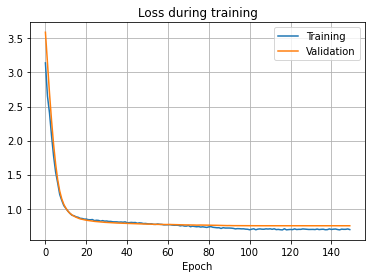

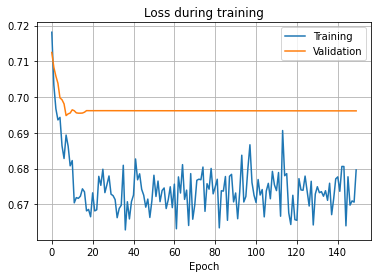

In [49]:
display_history(histories[model_nno])
display_history(histories[model_obj])

From the data we can infer the epoch that allowed the model to generalize better by inspecting the loss on data that it had never seen before (data on the validation set).

In [44]:
models = [model_nno, model_obj]
for model_idx in range(len(models)):
    if histories[models[model_idx]] is None:
        print(f'The data cannot be calculated since the history of the training of the model {model_idx + 1} is not available.')
    else:
        print(f'Model {model_idx + 1} currently uses the weights that have been determined on epoch {np.argmin(histories[models[model_idx]].history["val_loss"]) + 1}.')

Model 1 currently uses the weights that have been determined on epoch 95.
Model 2 currently uses the weights that have been determined on epoch 8.


The following classification reports sum up the performances of the trained networks with respect to the test data.

In [46]:
for i in range(len(models)):
    print(f'Classification report for the Model {i+1}:')    
    y_true = ds_splits[models[i]]['y_test']
    y_pred = np.argmax(models[i].predict(ds_splits[models[i]]['x_test']).logits,axis=-1)
    print(classification_report(y_true, y_pred, zero_division = 0))

Classification report for the Model 1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.56      0.20      0.29        25
           2       0.71      0.94      0.81        66

    accuracy                           0.70        96
   macro avg       0.42      0.38      0.37        96
weighted avg       0.63      0.70      0.63        96

Classification report for the Model 2:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        35
           1       0.50      0.32      0.39        25

    accuracy                           0.58        60
   macro avg       0.56      0.55      0.54        60
weighted avg       0.57      0.58      0.56        60



Once again, given the fact that only few records were available, we compare the performances of the networks with a random classifier.

In [50]:
random_experiment([model_nno, model_obj], [ds_splits[model_nno]['y_test'], ds_splits[model_obj]['y_test']], [{'min': 0, 'max': 2}, {'min': 0, 'max': 1}], 1000, 3)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 216.52it/s]

Approximation of the expected performances of a uniform random classifier for the task solved by Model 1
	Macro:
		Precision:
			Mean:0.333
			Var:0.002
		Recall
			Mean:0.334
			Var:0.004
		F1-score
			Mean:0.295
			Var:0.002
	Weighted:
		Precision:
			Mean:0.463
			Var:0.003
		Recall
			Mean:0.333
			Var:0.002
		F1-score
			Mean:0.368
			Var:0.003
Approximation of the expected performances of a uniform random classifier for the task solved by Model 2
	Macro:
		Precision:
			Mean:0.502
			Var:0.004
		Recall
			Mean:0.502
			Var:0.004
		F1-score
			Mean:0.498
			Var:0.004
	Weighted:
		Precision:
			Mean:0.511
			Var:0.004
		Recall
			Mean:0.502
			Var:0.004
		F1-score
			Mean:0.503
			Var:0.004


By comparing the averages we can be sure of the fact that that the models perform ever so slightly better than a random classifier. The performances make sense considering that only few records were available for training and by recalling the distribution of the classes in the provided dataset.

### Models with weighted classes

Recall the first histogram of the notebook: it showed that the distribution of the classes is not uniform. We'd like to take into account this unfortunate property of the dataset and to correct it by way of re-weighting the under-represented classes.

Defining some copies of the previous models:

In [18]:
model_nno_weighted = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=3)
model_obj_weighted = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=2, ignore_mismatched_sizes=True)

Retrieving the previous train, val, test splits:

In [19]:
ds_splits[model_nno_weighted] = ds_splits[model_nno]
ds_splits[model_obj_weighted] = ds_splits[model_obj]

Compiling the networks to prepare them for training (fine-tuning):

In [20]:
for model in [model_nno_weighted, model_obj_weighted]:
    model.distilbert.trainable = False
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate = stance_config.INIT_LR),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )

Now configuring the callbacks for the training of the networks:

In [21]:
model_nno_weighted_checkpoint = keras.callbacks.ModelCheckpoint(stance_config.MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER, save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss")
model_obj_weighted_checkpoint = keras.callbacks.ModelCheckpoint(stance_config.MODEL_OBJ_WEIGHTED_CHECKPOINT_FOLDER, save_best_only=True, save_weights_only=True, verbose=1, mode="min", monitor="val_loss")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=.1, patience=5, min_lr=stance_config.MIN_LR)

model_weighted_callbacks = {model_nno_weighted: [model_nno_weighted_checkpoint, reduce_lr], model_obj_weighted: [model_obj_weighted_checkpoint, reduce_lr]}

Ensuring that the folders needed to store the best weights of the networks exist:

In [22]:
os.makedirs(stance_config.MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER, exist_ok = True)
os.makedirs(stance_config.MODEL_OBJ_WEIGHTED_CHECKPOINT_FOLDER, exist_ok = True)

print('Model checkpoint folders created (if not existent). If the training has been already done, please copy the corresponding weights in the following folders:')
print(os.path.abspath(stance_config.MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER))
print(os.path.abspath(stance_config.MODEL_OBJ_WEIGHTED_CHECKPOINT_FOLDER))

Model checkpoint folders created (if not existent). If the training has been already done, please copy the corresponding weights in the following folders:
C:\Users\Andrea\Script Python\model_nno_checkpoint_weighted
C:\Users\Andrea\Script Python\model_obj_checkpoint_weighted


#### Training and evaluation

Starting the training of the networks (or loading the weights if available).

This time, the `class_weight` parameter has been set. Each class is assigned a weight that is inversely proportional to the fraction of records of the dataset having a certain class. By doing so, the under-represented classes will have more weight than the other classes.

In [24]:
histories = {model_nno_weighted: None, model_obj_weighted: None}

try:
    model_nno_weighted.load_weights(stance_config.MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER)
    model_obj_weighted.load_weights(stance_config.MODEL_OBJ_WEIGHTED_CHECKPOINT_FOLDER)
    print('The weights of the models have already been found. Skipping training.')

except:
    
    for model, epochs, batch_size in [(model_nno_weighted, stance_config.MODEL_NNO_WEIGHTED_EPOCHS, stance_config.MODEL_NNO_WEIGHTED_BATCH_SIZE),
                                      (model_obj_weighted, stance_config.MODEL_OBJ_WEIGHTED_EPOCHS, stance_config.MODEL_OBJ_WEIGHTED_BATCH_SIZE)]:

        histories[model] = model.fit(
            ds_splits[model]['x_train'], 
            ds_splits[model]['y_train'], 
            validation_data = (
                ds_splits[model]['x_val'],
                ds_splits[model]['y_val']
            ),
            epochs = epochs,
            callbacks = model_weighted_callbacks[model],
            batch_size = batch_size,
            #The classes are unbalanced, we re-weight the classes in such a way that underrepresented classes have more weight.
            #We weight considering the train set since the splitting was made in such a way that all the sets have the same distribution of classes.
            class_weight = pd.Series(ds_splits[model]['y_train']).value_counts().map(lambda x: len(ds_splits[model]['y_train'])/(2.*x)).to_dict()
        )

    #Finally, load the best weights obtained during the training:
    model_nno_weighted.load_weights(stance_config.MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER)
    model_obj_weighted.load_weights(stance_config.MODEL_OBJ_WEIGHTED_CHECKPOINT_FOLDER)

Epoch 1/150
48/48 [==============================] - ETA: 0s - loss: 5.1182 - sparse_categorical_accuracy: 0.3338
Epoch 1: val_loss improved from inf to 3.65844, saving model to ./model_nno_checkpoint_weighted\
48/48 [==============================] - 24s 388ms/step - loss: 5.1182 - sparse_categorical_accuracy: 0.3338 - val_loss: 3.6584 - val_sparse_categorical_accuracy: 0.2812 - lr: 1.0000e-05
Epoch 2/150
48/48 [==============================] - ETA: 0s - loss: 4.4595 - sparse_categorical_accuracy: 0.3469
Epoch 2: val_loss improved from 3.65844 to 3.28605, saving model to ./model_nno_checkpoint_weighted\
48/48 [==============================] - 18s 371ms/step - loss: 4.4595 - sparse_categorical_accuracy: 0.3469 - val_loss: 3.2861 - val_sparse_categorical_accuracy: 0.2812 - lr: 1.0000e-05
Epoch 3/150
48/48 [==============================] - ETA: 0s - loss: 4.2239 - sparse_categorical_accuracy: 0.3377
Epoch 3: val_loss improved from 3.28605 to 2.92811, saving model to ./model_nno_checkp

Let us inspect the history of the training of both networks:

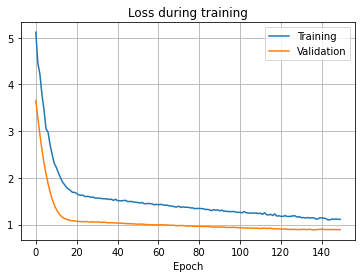

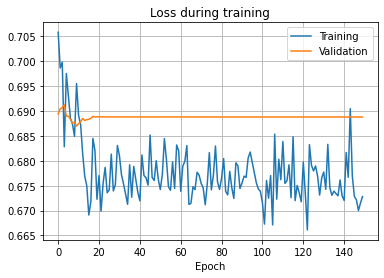

In [27]:
display_history(histories[model_nno_weighted])
display_history(histories[model_obj_weighted])

From the data we can infer the epoch that allowed the model to generalize better by inspecting the loss on data that it had never seen before (data on the validation set).

In [28]:
models = [model_nno_weighted, model_obj_weighted]
for model_idx in range(len(models)):
    if histories[models[model_idx]] is None:
        print(f'The data cannot be calculated since the history of the training of the model {model_idx + 1} is not available.')
    else:
        print(f'Model {model_idx + 1} currently uses the weights that have been determined on epoch {np.argmin(histories[models[model_idx]].history["val_loss"]) + 1}.')

Model 1 currently uses the weights that have been determined on epoch 137.
Model 2 currently uses the weights that have been determined on epoch 10.


The following classification reports sum up the performances of the trained networks with respect to the test data.

In [38]:
for i in range(len(models)):
    print(f'Classification report for the Model {i+1}:')    
    y_true = ds_splits[models[i]]['y_test']
    y_pred = np.argmax(models[i].predict(ds_splits[models[i]]['x_test']).logits,axis=-1)
    print(classification_report(y_true, y_pred, zero_division = 0))

Classification report for the Model 1:
              precision    recall  f1-score   support

           0       0.05      0.20      0.08         5
           1       0.39      0.60      0.48        25
           2       0.85      0.50      0.63        66

    accuracy                           0.51        96
   macro avg       0.43      0.43      0.40        96
weighted avg       0.69      0.51      0.56        96

Classification report for the Model 2:
              precision    recall  f1-score   support

           0       0.61      0.40      0.48        35
           1       0.43      0.64      0.52        25

    accuracy                           0.50        60
   macro avg       0.52      0.52      0.50        60
weighted avg       0.54      0.50      0.50        60



Once again, given the fact that only few records were available, we compare the performances of the networks with a random classifier.

In [30]:
random_experiment([model_nno_weighted, model_obj_weighted], [ds_splits[model_nno_weighted]['y_test'], ds_splits[model_obj_weighted]['y_test']], [{'min': 0, 'max': 2}, {'min': 0, 'max': 1}], 1000, 3)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.49it/s]

Approximation of the expected performances of a uniform random classifier for the task solved by Model 1
	Macro:
		Precision:
			Mean:0.332
			Var:0.002
		Recall
			Mean:0.331
			Var:0.006
		F1-score
			Mean:0.274
			Var:0.002
	Weighted:
		Precision:
			Mean:0.543
			Var:0.003
		Recall
			Mean:0.332
			Var:0.002
		F1-score
			Mean:0.386
			Var:0.003
Approximation of the expected performances of a uniform random classifier for the task solved by Model 2
	Macro:
		Precision:
			Mean:0.502
			Var:0.004
		Recall
			Mean:0.502
			Var:0.004
		F1-score
			Mean:0.496
			Var:0.004
	Weighted:
		Precision:
			Mean:0.515
			Var:0.004
		Recall
			Mean:0.502
			Var:0.004
		F1-score
			Mean:0.503
			Var:0.004


## Conclusions

To wrap up, we can see that the class re-weighting actually led to benefits for the first training but not for the second This makes sense, since only the dataset upon which the first network was trained was heavily unbalanced. For this reason, we consider the pipeline made of the following networks:
- `model_nno_weighted`;
- `model_obj`.

Finally, given these final models, it can also be interesting to inspect the performances of both models thought as a single one. In particular, we want to measure how well the models that have been defined, used in conjunction, predict all $4$ possible classes.

In [39]:
def stance_detection(queries:list, documents:list, model_nno: TFDistilBertForSequenceClassification, model_obj: TFDistilBertForSequenceClassification, tokenizer:DistilBertTokenizer) -> np.ndarray:
    """
    Given a list of queries and a list of document, the function returns the list of stances of the documents with respect to the queries.
    
    Args:
        queries (list): the list of queries
        documents (list): the documents. It can also be a string, in which case it's as if the function was called once for each query and the same document.
        model_nno (TFDistilBertForSequenceClassification): the model responsible of distinguishing between "No stance", "Neutral" and "Pro object"
        model_obj (TFDistilBertForSequenceClassification): the model responsible of distinguishing between "Pro 1st object" and "Pro 2nd object"
        tokenizer (DistilBertTokenizer): the tokenizer class used to tokenize the input of the TFDistilBertForSequenceClassification instances
        
    Returns:
        np.ndarray: NumPy array containing the stances of the document with respect to the queries. Possible values: 0: No stance, 1: Neutral, 2: Pro 1st object, 3: Pro 2nd object.
    """
    
    assert type(documents) == str or (type(documents) == list and len(documents) == len(queries)), "Invalid arguments."
    
    #Prepare the list of lists to give the tokenizer
    batch_df = pd.DataFrame(queries, columns = ['query'])
    batch_df['document'] = documents
    batch_LL = batch_df.values.tolist()

    #Tokenize the input
    tokenized_input = dict(tokenizer(batch_LL, padding=True, truncation='longest_first', return_tensors='tf'))
    #Predict the stance with the first model
    output = np.argmax(model_nno.predict(tokenized_input).logits,axis=-1)
    
    #Looking for "Pro object" predictions
    obj_idxs = np.argwhere(output == 2).flatten()

    #If some predictions have been "2"
    if obj_idxs.size > 0:

      #Considering the tokenization of the relevant inputs:
      tokenized_input['input_ids'] = tf.convert_to_tensor(tokenized_input['input_ids'].numpy()[obj_idxs,:])
      tokenized_input['attention_mask'] = tf.convert_to_tensor(tokenized_input['attention_mask'].numpy()[obj_idxs, :])
      
      #model_obj classifies "Pro 1st object" as "0" and "Pro 2nd object" as "1", but they should be classified respectively "2" and "3", therefore I add "2" to the classes. 
      output_2 = np.argmax(model_obj.predict(tokenized_input).logits,axis=-1) + 2

      #I replace output with output_2 where needed.
      output[obj_idxs] = output_2

    return output

To perform the evaluation, It would be fair to use only the records being in the test sets of both models. However:

In [40]:
print(f'Number of elements in the intersection of the test sets: {len(pd.merge(ds_splits_untok[model_nno]["x_test"], ds_splits_untok[model_obj]["x_test"]))}')

Number of elements in the intersection of the test sets: 7


We only show the number of elements in order to be sure to not accidentally show any records from the Yahoo dataset (as per license conditions).

For this reason, we test the performances of the combined model in the whole dataset.

In [47]:
predictions = stance_detection(df.question.values.tolist(), df.answer.values.tolist(), model_nno_weighted, model_obj, tokenizer)
true_values = df.answer_stance.values

In [48]:
print(f'Classification report for the final model:')    
print(classification_report(true_values, predictions, zero_division = 0))

Classification report for the final model:
              precision    recall  f1-score   support

           0       0.35      0.81      0.49        69
           1       0.59      0.63      0.61       287
           2       0.44      0.47      0.46       324
           3       0.45      0.25      0.32       276

    accuracy                           0.48       956
   macro avg       0.46      0.54      0.47       956
weighted avg       0.48      0.48      0.46       956



We present the comparison with the initial model evaluated in the same data:

In [61]:
predictions = np.argmax(model.predict(dict(tokenizer(df.loc[:, ['question','answer']].values.tolist(), padding=True, truncation='longest_first', return_tensors='tf'))).logits,axis=-1)
true_values = df.answer_stance.values

In [62]:
print(f'Classification report for the baseline model:')    
print(classification_report(true_values, predictions, zero_division = 0))

Classification report for the baseline model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.37      0.46      0.41       287
           2       0.36      0.37      0.37       324
           3       0.33      0.30      0.32       276

    accuracy                           0.35       956
   macro avg       0.27      0.29      0.27       956
weighted avg       0.33      0.35      0.34       956



Once again we also report the expected performances of a random classifier:

In [49]:
random_experiment(['final'],[true_values],[{'min': 0, 'max': 3}], 1000, 3)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.68it/s]


Approximation of the expected performances of a uniform random classifier for the task solved by Model 1
	Macro:
		Precision:
			Mean:0.249
			Var:0.000
		Recall
			Mean:0.249
			Var:0.000
		F1-score
			Mean:0.234
			Var:0.000
	Weighted:
		Precision:
			Mean:0.293
			Var:0.000
		Recall
			Mean:0.249
			Var:0.000
		F1-score
			Mean:0.264
			Var:0.000


The experiment has shown that the final model indeed performs better than a random classifier, even though the quantity of data available to train it was not ideal. Furthermore, the experiment provides some evidence in favour of the fact that we can actually gain something in terms of performances by splitting the networks as shown (compare the last classification report with the first one).

### Qrel evaluation

At the end we wanted to compare the performance of our models with the ones that the other teams were able to reach in the Touchè task.   
Therefore we downloaded the stance.qrels file and we run the model on that documents in order to get a classification for each text passage.

In [ ]:
# Download the stance qrels
url_stance = "https://zenodo.org/record/6873567/files/touche-task2-2022-stance.qrels?download=1"
file_path_stance = "stance.qrels"

download_stance = utils.manage_files.DownloadFile(file_path_stance, url=url_stance)
download_stance()

In [ ]:
stance_df = pd.read_csv(download_stance.file_name, index_col=None, 
                    names=["topic", "0", "doc_id", "stance"], sep=" ").drop("0", axis=1)

stance_df.head()

,topic,doc_id,stance
0,12,clueweb12-0002wb-18-34442___2,NO
1,12,clueweb12-0004wb-69-30215___112,NO
2,12,clueweb12-0004wb-78-20304___1,SECOND
3,12,clueweb12-0004wb-78-20304___11,NEUTRAL
4,12,clueweb12-0008wb-62-05967___1,NO


In [ ]:
# Download the list of topics (queries)
# Download and parse the xml file of the 0-50 topics
url_topics = "https://zenodo.org/record/6873559/files/topics-task-2.zip?download=1"
zip_path_topics = "topics-task-2.zip"
file_path_topics = "topics-task-2"

download_topics = utils.manage_files.DownloadFile(file_path_topics, zip_path_topics, url_topics)
download_topics()
# Retrieve a list of strings from the xml
topics = utils.manage_files.open_xml(download_topics.file_name + "/topics-task-2.xml")

# Topics from 51 to 100
url_topics_21 = "https://zenodo.org/record/6873565/files/topics-task-2-2021.zip?download=1"
zip_path_topics_21 = "topics-task-2-2021.zip"
file_path_topics_21 = "topics-task-2-2021"

download_topics_21 = utils.manage_files.DownloadFile(file_path_topics_21, zip_path_topics_21, url_topics_21)
download_topics_21()
topics += utils.manage_files.open_xml(download_topics_21.file_name + "/topics-task2-51-100.xml")

'C:\Users\Andrea\Downloads\downloads\zips\topics-task-2.zip' unzipped in 'C:\Users\Andrea\Downloads\downloads\topics-task-2'


'C:\Users\Andrea\Downloads\downloads\zips\topics-task-2-2021.zip' unzipped in 'C:\Users\Andrea\Downloads\downloads\topics-task-2-2021'


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")
model_nno = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=3)
model_obj = TFDistilBertForSequenceClassification.from_pretrained("typeform/distilbert-base-uncased-mnli", num_labels=2, ignore_mismatched_sizes=True)

model_nno.load_weights(stance_config.MODEL_NNO_WEIGHTED_CHECKPOINT_FOLDER)
model_obj.load_weights(stance_config.MODEL_OBJ_CHECKPOINT_FOLDER) 

In [ ]:
def stance_detection_qrels(queries, stance_df, model_nno, model_obj, tokenizer, corpus_df):
    '''
        It returns the results of the stance detection for each topic and document that are in the 
        stance_df dataframe.

        Parameters:
            - queries: list[str]
                The list of topics.
            - stance_df: pd.DataFrame
                The dataframe that contains the topics, document ids and stances of the .qrels file.
            - model_nno: TFDistilBertForSequenceClassification
                The model responsible of distinguishing between "No stance", "Neutral" and "Pro object".
            - model_obj: TFDistilBertForSequenceClassification
                The model responsible of distinguishing between "Pro 1st object" and "Pro 2nd object".
            - tokenizer: DistilBertTokenizer
                The tokenizer class used to tokenize the input of the TFDistilBertForSequenceClassification instances.

        Returns:
            - pd.DataFrame
                The dataframe that contains the stances computed by the model for each element within the .qrels file.
    '''

    # Where to append the results
    trec = pd.DataFrame(columns=['topic', 'doc_id', 'stance'])
    # Loop over the topic ids
    for topic in stance_df.topic.unique():
        print(f"Computing topic {topic} ...")
        # Get the text for each document relative to a topic inside the stance_df
        documents = [corpus_df[corpus_df['id']==docid]['contents'].item() for docid in stance_df[stance_df['topic']==topic]['doc_id']]
        batch_df = pd.DataFrame([queries[topic-1] for _ in range(len(documents))], columns=['query'])

        batch_df['document'] = documents
        batch_LL = batch_df.values.tolist()
        #Tokenize the input
        tokenized_input = dict(tokenizer(batch_LL, padding=True, truncation='longest_first', return_tensors='tf'))
        #Predict the stance with the first model
        output = np.argmax(model_nno.predict(tokenized_input, verbose=0).logits,axis=-1)
        #Looking for "Pro object" predictions
        obj_idxs = np.argwhere(output == 2).flatten()

        #If some predictions have been "2"
        if obj_idxs.size > 0:
            #Considering the tokenization of the relevant inputs:
            tokenized_input['input_ids'] = tf.convert_to_tensor(tokenized_input['input_ids'].numpy()[obj_idxs,:])
            tokenized_input['attention_mask'] = tf.convert_to_tensor(tokenized_input['attention_mask'].numpy()[obj_idxs, :])
            
            #model_obj classifies "Pro 1st object" as "0" and "Pro 2nd object" as "1", but they should be classified respectively "2" and "3", therefore I add "2" to the classes. 
            output_2 = np.argmax(model_obj.predict(tokenized_input, verbose=0).logits,axis=-1) + 2
            #I replace output with output_2 where needed.
            output[obj_idxs] = output_2

        trec = trec.append(pd.DataFrame(zip([topic for _ in range(len(documents))], 
                                            stance_df[stance_df['topic']==topic]['doc_id'].tolist(),
                                            output.tolist()), 
                                        columns=['topic', 'doc_id', 'stance']))
    return trec


In [ ]:
url_corpus = "https://zenodo.org/record/6873567/files/touche-task2-passages-version-002.jsonl.gz?download=1"
corpus_df = utils.manage_files.open_df(utils.manage_files.download_files(url_corpus))


'C:\Users\Andrea\Downloads\downloads\touche-task2-passages-version-002.jsonl' already present


In [ ]:
res_qrels = stance_detection_qrels(topics, stance_df, model_nno, model_obj, tokenizer, corpus_df)

Computing topic 12 ...
Computing topic 28 ...
Computing topic 34 ...
Computing topic 37 ...
Computing topic 68 ...
Computing topic 92 ...
Computing topic 100 ...
Computing topic 9 ...
Computing topic 22 ...
Computing topic 26 ...
Computing topic 53 ...
Computing topic 58 ...
Computing topic 84 ...
Computing topic 95 ...
Computing topic 17 ...
Computing topic 19 ...
Computing topic 25 ...
Computing topic 27 ...
Computing topic 36 ...
Computing topic 51 ...
Computing topic 76 ...
Computing topic 55 ...
Computing topic 56 ...
Computing topic 67 ...
Computing topic 69 ...
Computing topic 72 ...
Computing topic 78 ...
Computing topic 86 ...
Computing topic 93 ...
Computing topic 30 ...
Computing topic 42 ...
Computing topic 54 ...
Computing topic 59 ...
Computing topic 61 ...
Computing topic 77 ...
Computing topic 88 ...
Computing topic 8 ...
Computing topic 18 ...
Computing topic 33 ...
Computing topic 60 ...
Computing topic 62 ...
Computing topic 74 ...
Computing topic 91 ...
Computing to

In [25]:
stance_map = {'NO': 0, 'NEUTRAL': 1, 'FIRST': 2, 'SECOND': 3}

In [30]:
print(classification_report(stance_df['stance'].map(lambda x: stance_map[x]).values.tolist(), res_qrels['stance'].values.tolist()))

              precision    recall  f1-score   support

           0       0.64      0.32      0.43      1012
           1       0.22      0.44      0.30       418
           2       0.24      0.39      0.30       393
           3       0.19      0.10      0.13       284

    accuracy                           0.33      2107
   macro avg       0.32      0.31      0.29      2107
weighted avg       0.42      0.33      0.34      2107

